# Benchmark: Brownian motion
> We benchmark STEP studying Brownian motion trajectories with changes.

In [ ]:
#| hide
from step.data import *
from step.models import *
from step.utils import *
from step.baselines import diffusion_coefficient_tamsd, ruptures_cp

from tqdm.auto import tqdm
from fastai.vision.all import *

The main goal is to characterize heterogeneous diffusion processes without any kind of prior konwledge. To do so, we predict the diffusion coefficient at every time step, which naturally highlights potential changes in the behaviour along the trajectories. This allows us to obtain a deeper understanding of the underlying physical systems that drive the dynamics. 

In the following analysis, we provide a thorough characterization of the model performance under various conditions and we show how to reproduce some figures of [our paper](https://arxiv.org/abs/2302.00410).

# Load the model
First of all, we need to load a trained model with which to perform the analysis.

::: {.callout-note}
We refer to the [model training tutorial](https://borjarequena.github.io/step/tutorials/model_training.html) for details about how to train and save your models.
:::

To load the models within a `Leaner`, we need to provide some data loaders. However, we will use the model to study various scenarios, so we provide an empty dataloader and load the different data sets as we need them.

In [ ]:
dim = 2
dls = DataLoaders.from_dsets([], []) # Empty train and validation datasets
model = XResAttn(dim, n_class=1, stem_szs=(64,), conv_blocks=[1, 1, 1],
                 block_szs=[128, 256, 512], pos_enc=False,
                 n_encoder_layers=4, dim_ff=512, nhead_enc=8,
                 linear_layers=[], norm=False, yrange=(-3.1, 3.1))
model.to(default_device())
learn_diff = Learner(dls, model, loss_func=L1LossFlat(), model_dir=MODEL_PATH)

Now we can load the trained model weights.

In [ ]:
learn_diff.load(f'xresattn_bm_{dim}d_1_to_4cp')
learn_diff.model.eval();

::: {.callout-warning}
It is very important to define the model exactly with the same layers as we did during training. Otherwise, we won't be able to load the trained parameters!
:::

# Pointwise prediction

We study the overall performance of the method over heterogeneous Brownian motion trajectories. We look at the pointwise prediction error and study how the length of the segments within the trajectory affect it.

We compare our approach with a reference method based on the time-averaged mean squared displacement (TA-MSD) (see [baselines](https://borjarequena.github.io/step/source/baselines.html)). However, since this method cannot account for any heterogeneity in the trajectories, we provide it with the pre-segmented trajectories. This results in a massive advantage and, thus, we also pass the pre-cut segments through our model.

With this segment-wise analysis, we can easily study the performance of all the methods as function of the segment lengths.

::: {.callout-note}
We consider diffusion coefficients over six orders of magnitude $D\in[10^{-3},10^3]$. Some times, our observations may fall outside of this range and our predictions saturate to one of the interval limits. In these cases, we can rescale the trajectories to fit within the predicted range, as we do in the experimental data analysis tutorials.
:::

## Generate the data

To evaluate the different methods, we need a proper test set. We can generate one in the same way that we genereate the train set in the [model training tutorial](https://borjarequena.github.io/step/tutorials/model_training.html).

::: {.callout-note}
Skip the data generation if you already have a test set!
:::

In [ ]:
# OPTIONAL: create the test set.
# Don't need to run this cell if it already exists.
n_per_set, max_t, dim = 12000, 200, 2
Ds = np.logspace(-3, 3, 1000) 
cps = [1, 2, 3, 4]
ds_fun = partial(create_bm_segmentation_dataset,
                 max_t=max_t, dim=dim, Ds=Ds, save=False)
datasets = [ds_fun(n_per_set, n_change_points=n_cp) for n_cp in cps]
ds = combine_datasets(datasets)
n_change = f"{min(cps)}_to_{max(cps)}"
save_path = DATA_PATH/get_bmds_fname(n_change, max_t, dim, 'test')
ds.to_pickle(save_path)

Load the test set.

In [ ]:
# Skip this cell if you just generated it.
n_change = "1_to_4"
name = "test"
ds = load_dataset(n_change=n_change, dim=dim, bm=True, name=name)

We also load the data as data loaders with `split_pct=1` (all data for validation). This allows us to loop over batches much more easily setting `shuffle=False`.

In [ ]:
bs = 200
dls = get_segmentation_dls(target='y_exp', dim=dim, n_change=n_change,
                           name=name, tfm_y=torch.log10, bm=True, bs=bs,
                           shuffle=False, split_pct=1.)
dls.device = default_device()

## Get the predictions

We now perform the predictions of the trajectories as a whole and store them in the dataframe to process them later.

In [ ]:
for i, (x, y) in tqdm(enumerate(dls.valid)):
    pred = to_detach(learn_diff.model(x).squeeze())
    mae = to_detach((learn_diff.model(x).squeeze()-y).abs().mean(-1))
    l_pred = np.array([p for p in pred], dtype=object)
    ds.loc[i*bs:(i+1)*bs-1, 'mae'] = mae.numpy()
    ds.loc[i*bs:(i+1)*bs-1, 'pred'] = l_pred

0it [00:00, ?it/s]

With the full-trajectory predictions, we can proceed to perform the segment-wise analysis. We split the trajectories and their predictions by the *true* changepoints. Then, we perform the prediction especifically for each segment with both the model and the TA-MSD method. We choose the TA-MSD 1-2 to perform the evaluation, which is optimal for Brownian motion.

Let's define a prediction function to simplify the code.

In [ ]:
def predict_sample(model, x):
    xb = x.unsqueeze(0).to(default_device())
    return to_detach(model(xb).squeeze())

Now we can proceed to process the trajectories. The following piece of code is rather chonky so let us give a brief overview. For every trajectory (outer loop), we process each of its segments (inner loop). For every segment, we compute the mean absolute error (MAE) and the mean relative error with the three aforementioned approaches.

In [ ]:
segment_data = []

for i, row in tqdm(ds.iterrows()):
    x, y,= row.x, torch.log10(row.y_exp.squeeze())
    pred, cps = row.pred, row.cp
    split_x = split_tensor(x.T, cps)
    split_y, split_pred = split_tensor(y, cps), split_tensor(pred, cps)
    
    splits = zip(split_x, split_y, split_pred)
    for j, (seg_x, seg_y, pred_cut) in enumerate(splits):
        # Prediction over full trajectory cut with true changepoints
        mae = mean_absolute_error(pred_cut, seg_y)
        rel_err = mean_relative_error(pred_cut, seg_y)
        
        # Prediction over segment
        pred_segment = predict_sample(learn_diff.model, seg_x - seg_x[0])
        mae_segment = mean_absolute_error(pred_segment, seg_y)
        rel_err_segment = mean_relative_error(pred_segment, seg_y)
        
        # Prediction over segment with TA-MSD
        pred_tamsd = diffusion_coefficient_tamsd(seg_x)
        mae_tamsd = mean_absolute_error(pred_tamsd, 10**seg_y[0])
        rel_err_tamsd = (pred_tamsd*10**(-seg_y[0]) - 1).abs()
        
        # Save the segment metrics
        segment_data.append({'sample': i, 'segment_idx': j,
                             'length': len(seg_y), 'x': seg_x, 'y': seg_y,
                             'pred_cut': pred_cut,
                             'pred_segment': pred_segment,
                             'pred_tamsd': pred_tamsd, 'mae': mae,
                             'rel_err': rel_err, 'mae_segment': mae_segment,
                             'rel_err_segment': rel_err_segment,
                             'mae_tamsd': mae_tamsd,
                             'rel_err_tamsd': rel_err_tamsd})
segment_ds = pd.DataFrame.from_records(segment_data)

0it [00:00, ?it/s]

Finally, we save all the data for its posterior post-processing. It is extremely heavy and slow :D

In [ ]:
segment_ds.to_pickle(DATA_PATH/"segment_analysis_test.pkl")

## Overall performance

To obtain an intuition of our model's performance, we can do a qualitative analysis by looking at the predicted diffusion coefficient $D_{\text{pred}}$ as function of the ground truth $D_{\text{true}}$ at every time step.

To do so, we simply concatenate the predictions for every segment `segment_ds.pred_cut` and their true labels `segment_ds.y`.

In [ ]:
true = np.concatenate([*segment_ds.y])
pred = np.concatenate([*segment_ds.pred_cut])

Now we can build the 2D histogram.

In [ ]:
bins = [np.linspace(-3, 3, 61), np.linspace(-3.1, 3.1, 63)]
hist, true_edges, pred_edges = np.histogram2d(true, pred, bins=bins)

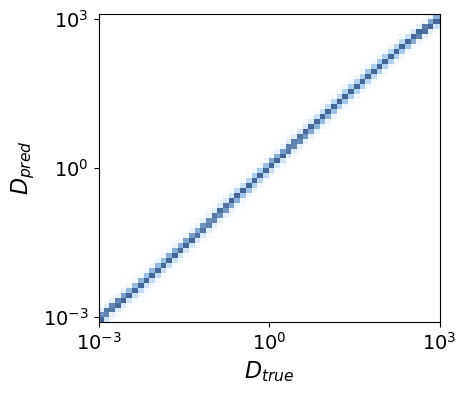

In [ ]:
#| code-fold: true
fig = plt.figure(figsize=(1.1*fig_size, fig_size))
plt.pcolor(hist.transpose()/hist.max(), cmap=cmap_hist1, vmax=0.8, rasterized=True)
xtick_pos = np.linspace(0, len(true_edges) - 1, np.ceil(len(true_edges)/30).astype(int))
xtick_labels = [fr'$10^{{{i:.0f}}}$' for i in true_edges[::30]]
ytick_pos = np.linspace(0, len(pred_edges) - 3, np.ceil(len(pred_edges)/30).astype(int)) + 1
ytick_labels = [fr'$10^{{{i:.0f}}}$' for i in pred_edges[1::30]]
plt.yticks(ytick_pos, labels=ytick_labels)
plt.ylabel(r'$D_{pred}$', fontsize=16)
plt.xticks(xtick_pos, xtick_labels)
plt.xlabel(r'$D_{true}$', fontsize=16)
plt.tick_params(labelsize=14)

The histogram shape is close to a perfect regressor, where we would obtain a straight diagonal line. Therefore, the model seems to be working pretty nicely!

## Prediction error

To obtain a quantitative analysis, we can look at the relative error of the different methods.

In [ ]:
lengths = segment_ds.length.unique().astype(int)
lengths.sort()

metrics = ['err', 'err_segment', 'err_tamsd']
metric_by_length = {m: {'mean': [], 'sem': [], 'global': None}
                    for m in metrics}

for m in metrics:
    means = [getattr(segment_ds, f"rel_{m}")[segment_ds.length == l].mean()
             for l in lengths]
    sems = [getattr(segment_ds, f"rel_{m}")[segment_ds.length == l].sem()
            for l in lengths]
        
    metric_by_length[m]['mean'] = np.array(means)
    metric_by_length[m]['sem'] = np.array(sems)
    metric_by_length[m]['global'] = (
        (getattr(segment_ds, f"rel_{m}")*segment_ds.length).sum() /
         segment_ds.length.sum()
    )

We save all these metrics to plot them nicely later.

In [ ]:
figure_name = "relative_error_segment_length"
plot_data_path = (FIG_PATH/figure_name).with_suffix(".pkl")

with open(plot_data_path, 'wb') as f:
    pickle.dump(metric_by_length, f, protocol=pickle.HIGHEST_PROTOCOL)

Let's see the overall relative error for each method.

In [ ]:
#| code-fold: true
print(f"STEP: {metric_by_length_D['err']['global']:.3f}")
print(f"STEP + segments: {metric_by_length_D['err_segment']['global']:.3f}")
print(f"TA-MSD + segments: {metric_by_length_D['err_tamsd']['global']:.3f}")

STEP: 0.226
STEP + segments: 0.189
TA-MSD + segments: 0.249


STEP outperforms the TA-MSD baseline despite its disadvantage. It even reduces the error by $\sim 25\%$ when we consider the pre-segmented trajectory! In the plot right below, we see the prediction error over segments at different lengths.

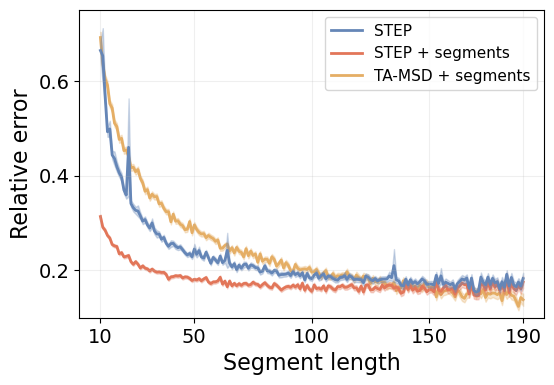

In [ ]:
#| code-fold: true
fig = plt.figure(figsize=(1.5*fig_size, fig_size))
labels = ['STEP', 'STEP + segments', 'TA-MSD + segments']
markers = ['o', 's', 'D']

for i, m in enumerate(metric_by_length.keys()):
    mean, sem = metric_by_length[m]['mean'], metric_by_length[m]['sem']
    plt.plot(lengths, mean, color=colors[i], label=labels[i],
             zorder=zorder, lw=linewidth)
    plt.fill_between(lengths, mean - sem, mean + sem, color=colors[i],
                     alpha=0.3, zorder=-i)

plt.grid(alpha=alpha_grid)
plt.legend(fontsize=11)
plt.tick_params(labelsize=14)
plt.ylim([0.1, 0.75])
plt.xticks([10, 50, 100, 150, 190])
plt.yticks([0.2, 0.4, 0.6])
plt.xlabel("Segment length", fontsize=16)
plt.ylabel("Relative error", fontsize=16);

STEP systematically outperforms the TA-MSD baseline for short segments. Furthermore, when we provide it with the isolated segments, we can achieve outstanding low errors, specially for the shortest segments. This is reasonable because the shorter segments carry much less information to properly determine $D$, and they can even be confused with simple stochastic fluctuations of the phenomena. This makes it harder to accurately determine the segment boundaries, as shown by the difference between the blue and red lines. 

# Changepoint detection

While our approach does not explicitly provide any changepoints, changes in diffusion properties emerge naturally in the predictions. Thus, we can use them to enhance dedicated changepoint detection algorithms. Here, we use the [ruptures library](https://centre-borelli.github.io/ruptures-docs/), which implements a kernel changepoint detection algorithm (see [baselines](https://borjarequena.github.io/step/source/baselines.html#ruptures) and their [review paper](https://www.sciencedirect.com/science/article/abs/pii/S0165168419303494?via%3Dihub)).

We compare the results obtained applying ruptures over the trajectory displacements and over the STEP predictions. To quantify the performance, we compute the Jaccard index (JI) between the predicted changepoints and the ground truh. This metric can account for false positives and false negatives (see our [model evaluation methods](https://borjarequena.github.io/step/source/utils.html#model-evaluation)), which is very important in these cases as the changepoint detection algorithm will infer the number of changepoints, meaning that there may be a different number of predicted and ground truth changepoints.

::: {.callout-note}
The Jaccard index is a function of the true positives (TP), false positives (FP), and false negatives (FN): $$JI = \frac{TP}{TP + FP + FN}\,.$$ Intuitively, it provides the percentage of correct predictions out of all of them.
:::

Then, we also compute the mean squared error (MSE) between the predicted and their corresponding true changepoints.


## Generate the data

In order to obtain a better insight about the strengths of the methods, we test them in trajectories with one single changepoint. In this way, we study how the changepoint position and difference between diffusion coefficient in consecutive segments affects the performance.

In [ ]:
Ds = np.logspace(-3, 3, 1000) 
ds = create_bm_segmentation_dataset(50000, dim=dim, Ds=Ds)

In [ ]:
ds['y'] = ds['y_exp'].apply(torch.squeeze)
ds['y_log'] = ds['y'].apply(torch.log10)
ds['D_diff'] = ds['y_log'].apply(lambda x: (x[1] - x[0]).item())
ds['cp'] = ds['cp'].apply(lambda x: x.numpy())
ds = ds.drop(columns=['y_mod', 'y_exp', 'models', 'exps'])

## Get the predictions

Let's get the predictions! We define a couple of functions to make our code more readable.

In [ ]:
def make_batch(df, i, bs, col='x'):
    "Return a batch of samples from df."
    samples = [x.transpose(-1, 0) for x in ds.loc[i*bs:(i+1)*bs-1, col]]
    return torch.stack(samples, dim=0)

def predict(model, x):
    "Get prediction of `model` on batch `x`."
    return to_detach(model(x.to(default_device())).squeeze()

Ready to go!

In [ ]:
bs = 400
n_batch = np.ceil(ds.shape[0]/bs).astype(int)
for i in tqdm(range(n_batch)):
    xb = make_batch(ds, i, bs)
    pred = predict(learn_diff.model, xb)
    ds.loc[i*bs:(i+1)*bs-1, 'pred'] = np.array([p for p in pred],
                                               dtype=object)

  0%|          | 0/125 [00:00<?, ?it/s]

Let's save this for later.

In [ ]:
ds_path = DATA_PATH/get_bmds_fname(1, max_t, dim, 'with_preds')
ds.to_pickle(ds_path)

## Overall performance

Let's compute the JI for the task using the STEP predictions and the trajectory displacements for the kernel changepoint prediction algorithm in ruptures.

To ease the code readability, we define a function to combine two dictionaries together (adhoc for our purposes).

In [ ]:
def merge_dict(dict_1, dict_2):
    "Merge the information of two dictionaries."
    merge = {}
    for k, v1 in dict_1.items():
        v2 = dict_2.get(k, [])
        if isinstance(v1, Iterable) and isinstance(v2, Iterable):
            merge[k] = [*v1, *v2]
        elif isinstance(v1, Iterable):
            merge[k] = [*v1, v2]
        elif isinstance(v2, Iterable):
            merge[k] = [v1, *v2]
        else:
            merge[k] = [v1, v2]
    return merge

Now we process every trajectory and retrieve the changepoints with ruptures using both the displacements and the STEP prediction. Then, we compute the JI between the prediction and the ground truth and, finally, the MSE for the true positives.

In [ ]:
method_pen = {'pred': 2., 'displ': 6.}
methods = list(method_pen.keys())

metrics_method = {m: {} for m in methods}
for i, row in tqdm(ds.iterrows()):
    traj, pred, true_cp = row.x.numpy(), row.pred.numpy(), row.cp
    displacements = np.log(get_displacements(traj))

    for m in methods:
        seg_data = (pred if m == 'pred'
                    else displacements if m == 'displ'
                    else None)
        pred_cp = ruptures_cp(seg_data, pen=method_pen[m], min_size=5)
        metrics = evaluate_cp_prediction(true_cp, pred_cp)
        metrics_method[m] = merge_dict(metrics, metrics_method[m])
        for k, v in metrics.items():
            if metrics['tp']:
                ds.loc[i, f'cp_{m}_{k}'] = v[0] if k == 'sq_error' else v
            else:
                ds.loc[i, f'cp_{m}_{k}'] = -1 if k == 'sq_error' else v

Now we can compute the overall JI and MSE for both approaches over the whole test set. 

In [ ]:
method_mse, method_j_idx = {}, {}
for m, v in metrics_method.items():
    method_mse[m] = np.mean(v['sq_error'])
    tp, fp, fn = np.sum(v['tp']), np.sum(v['fp']), np.sum(v['fn'])
    method_j_idx[m] = jaccard_index(tp, fp, fn)

0it [00:00, ?it/s]

In [ ]:
method_j_idx, method_mse

({'pred': 0.8333494778851929, 'displ': 0.7963921392139214},
 {'pred': 0.6803905614320586, 'displ': 0.6163644925829997})

We see that running rutpures on top of STEP increases the JI from 0.796 to 0.833, meaning that we reduce the errors by about $20\%$. It is natural to expect that, by detecting more changepoints (higher JI), the method then incurs a larger MSE. This is because we consider a threshold of $\mathcal{E}=5$ points from the ground truth to count the predictions as true positive. The results indicate that the additional changepoints detected with STEP lie, most likely, at the limit of the threshold.

## Difference between consecutive segments

Now that we have an idea of the overall behaviour of both methods, let's look at the JI as function of the relative difference between $D$ of consecutive segments. Inuitively, the larger the difference, the easier it is to detect where the change is happening.

::: {.callout-note}
Beware that the difference in log space is the ratio in real space. Don't get confused :)
:::

In [ ]:
bins_D_diff = np.linspace(-6, 6, 100) # Difference in log space
j_idx_by_diff = {m: [] for m in methods}
mse_by_diff = {m: [] for m in methods}

for low, high in zip(bins_D_diff[:-1], bins_D_diff[1:]):
    mask = (ds.D_diff >= low) & (ds.D_diff < high)
    for m in methods:
        tp = ds.loc[mask, f'cp_{m}_tp'].sum()
        fp = ds.loc[mask, f'cp_{m}_fp'].sum()
        fn = ds.loc[mask, f'cp_{m}_fn'].sum()
        j_idx_by_diff[m].append(jaccard_index(tp, fp, fn))
        
        mask_mse = mask & (ds.loc[:, f'cp_{m}_tp'] == 1)
        mse_by_diff[m].append(ds.loc[mask_mse, f'cp_{m}_sq_error'].mean())

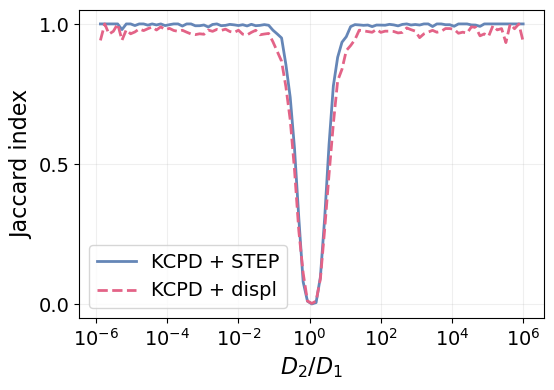

In [ ]:
#| code-fold: true
method_color = {'pred': colors[0], 'displ': colors_light[3]}
method_label = {'pred': 'KCPD + STEP', 'displ': 'KCPD + displ'}
method_ls = {'pred': 'solid', 'displ': 'dashed'}

fig = plt.figure(figsize=(1.5*fig_size, fig_size))
plt_x = bins_D_diff[:-1] + np.diff(bins_D_diff)
for m in methods:
    plt.plot(plt_x, j_idx_by_diff[m], linewidth=linewidth, label=method_label[m],
              color=method_color[m], linestyle=method_ls[m])
plt.grid(alpha=alpha_grid)
plt.ylim([-0.05, 1.05])
plt.yticks([0., 0.5, 1.])
plt.xticks(np.arange(-6, 7, 2), [f"$10^{{{t}}}$" for t in np.arange(-6, 7, 2)])
plt.legend(fontsize=14)
plt.xlabel(r"$D_2/D_1$", fontsize=16)
plt.ylabel("Jaccard index", fontsize=16)
plt.tick_params(labelsize=14)

We see that the changepoint method with STEP does, indeed, outperform the baseline for the whole range of $D_2/D_1$. They converge to the same results in the limit of very similar diffusion coefficients $D_2\approx D_1$, where the changes is barely detectable. Indeed, when $D_2=D_1$ there is no change to detect!

Interestingly, we get a nearly perfect detection when the diffusion coefficients are just one order of magnitude appart.

## Changepoint position

We can also study the impact of the changepoint position in the detection, which was shown to be a very important factor in the [AnDi Challenge](https://www.nature.com/articles/s41467-021-26320-w). Shorter segments are much harder to characterize and, by the same principle we saw the error increase for short segments, we expect the performance to drop when the change point is near the trajectory ends.

In [ ]:
bins_cp_pos = np.arange(10, 200, 10)
j_idx_by_position_D = {m: [] for m in methods}
for low, high in zip(bins_cp_pos[:-1], bins_cp_pos[1:]):
    mask = (low <= ds.cp) & (ds.cp < high)
    for m in methods:
        tp = ds.loc[mask, f'cp_{m}_tp'].sum()
        fp = ds.loc[mask, f'cp_{m}_fp'].sum()
        fn = ds.loc[mask, f'cp_{m}_fn'].sum()
        j_idx_by_position_D[m].append(jaccard_index(tp, fp, fn))

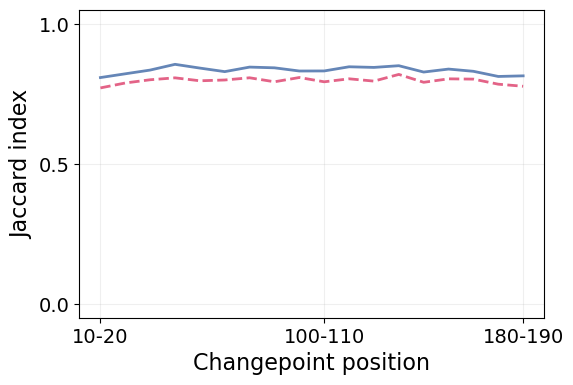

In [ ]:
#| code-fold: true
fig = plt.figure(figsize=(1.5*fig_size, fig_size))
for m in methods:
    plt.plot(j_idx_by_position_D[m], linewidth=linewidth, label=method_label[m],
              color=method_color[m], linestyle=method_ls[m])
x_tick_idx = np.array([0, 9, 17])
plt.xticks(x_tick_idx, 
           [f'{low}-{high}' for low, high in zip(bins_cp_pos[x_tick_idx], bins_cp_pos[x_tick_idx+1])])
plt.grid(alpha=alpha_grid)
plt.ylim([-0.05, 1.05])
plt.yticks([0., 0.5, 1.])
plt.ylabel("Jaccard index", fontsize=16)
plt.xlabel("Changepoint position", fontsize=16)
plt.tick_params(labelsize=14)

Again, we clearly see how STEP outperforms the baseline with trajectory displacements in all circumstances. Furthermore, both methods show impressive resilience to the changepoint position, as their performance is barely affected by it.

# Effect of the number of segments

An important factor to consider is the number of segments along trajectories. We have trained our models over trajectories with 2 to 5 segments, so it is very important to assess whether they can generalize to an arbitrary number of segments.

Here, we study the pointwise prediction error and the Jaccard index for the changepoint detection in trajectories with various segments of constant length.

## Generate the data

We generate a data set comprised of trajectories with different number of segments at several constant segment lengths. This way, we can look at the impact of both the number of segments and their lengths separately.

We define our custom methods here just for this test, provided that we do not have adhoc functions to generate this kind of data. You can skip these cells if you already have a test set.

In [ ]:
@delegates(brownian_motion)
def constant_segment_trajs(N, segment_length, n_change_points=1,
                                  Ds=np.logspace(-3, 3, 1000), **kwargs):
    "Create `N` trajectories with constant segment length."
    n_segments = n_change_points + 1
    max_t = n_segments * segment_length
    segment_D = np.random.choice(Ds, size=(N, n_segments))
    point_D = np.repeat(segment_D, segment_length, axis=-1)[:, None, :]
    bms = brownian_motion(N, max_t, point_D, **kwargs)
    return bms, point_D

def create_constant_segment_dataset(N, segment_length,
                                    n_change_points=1, dim=2):
    "Creates a dataset of `N` trajectories with constant segment length."
    data = []
    trajs, labels = constant_segment_trajs(N, segment_length, 
                                           n_change_points=n_change_points,
                                           dim=dim)
    length = trajs.shape[-1]
    cp = np.arange(segment_length, length, segment_length)
    for traj, label in zip(trajs, labels):
        x, y = tensor(traj), tensor(label).squeeze()
        data.append({'dim': dim, 'len': length, 'seg_len': segment_length,
                        'n_cp': n_change_points, 'cp': cp,
                        'x': x, 'y': y, 'y_log': torch.log10(y)})
    return pd.DataFrame.from_records(data)

With these functions, we can easily create our data set. We consider trajectories with none to 10 changepoints and segment lengths of 20, 40 and 60.

In [ ]:
n_set, segment_lengths, cps = 2000, [20, 40, 60], np.arange(11)
Ds = np.logspace(-3, 3, 1000) 
datasets = [create_constant_segment_dataset(n_set, sl, n_change_points=n_cp) 
            for sl in segment_lengths for n_cp in tqdm(cps)]
ds = combine_datasets(datasets, shuffle=False)

## Get the predictions

With our dataset ready, we can proceed to perform the predictions. We store them in the same dataframe. 

In [ ]:
bs = 50
n_batch = np.ceil(ds.shape[0]/bs).astype(int)
for i in tqdm(range(n_batch)):
    xb = make_batch(ds, i, bs).to(default_device())
    pred = to_detach(learn_diff.model(xb)).squeeze()
    ds.loc[i*bs:(i+1)*bs-1, 'pred'] = np.array([p for p in pred], dtype=object)

## Pointwise error

So far, we have characterized the prediction error with various metrics, such as the mean absolute error or the relative error, which focus on the pointwise performance.

However, the pointwise relative error is a rather volatile quantity. For instance, in the case there is a large change between consecutive diffusion coefficients, e.g., from $10^3$ to $10^{-3}$, even if the agent performs a perfect characterization, but fails by a single point, the relative error for the whole trajectory shoots up to $\sim10^6$. Therefore, in order to obtain a better understanding of the actual prediction error, $D_{\text{true}} - D_{\text{pred}}$, we consider the mean prediction of each segment $D_{\text{true}} - \langle D_{\text{pred}}\rangle_{\text{seg}}$. 

In [ ]:
def segment_rel_error(pred, y, cp):
    "Segment-wise relative error. Assumes `pred` and `y` in log10."
    segment_preds = split_tensor(pred, cp)
    segment_means = torch.stack([p.mean() for p in segment_preds])
    true_values = torch.cat([y[0].unsqueeze(0), y[cp]])
    return (10**(segment_means - true_values) - 1).abs().mean()

In [ ]:
# metrics
ds['mae'] = (ds['pred'] - ds['y_log']).abs().apply(torch.mean)
ds['seg_rel_error'] = ds.apply(lambda x: segment_rel_error(x['pred'],
                                                           x['y_log'], x['cp']),
                                                           axis=1)

Save the data for posterior processing.

In [ ]:
ds_path = DATA_PATH/"constant_segment_analysis.pkl"
ds.to_pickle(ds_path)

Finally, we compute the value of the relative erorr as a function of the number of change points.

In [ ]:
def get_metric_sem_per_cp(metric, ds):
    "Returns the metric per change point from dataset ds."
    segment_lengths = ds.seg_len.unique().astype(int)
    n_cps = ds.n_cp.unique().astype(int)
    metric_per_cp = np.zeros((len(segment_lengths), len(n_cps)))
    err_per_cp = np.zeros_like(metric_per_cp)                         
    for k, length in enumerate(segment_lengths):
        mask = (ds.seg_len == length) & (ds.n_cp == n_cp)
        metric_per_cp[k, :] = np.array([getattr(ds, metric)[mask].mean()
                                        for n_cp in n_cps])
        err_per_cp[k, :] = np.array([getattr(ds, metric)[mask].sem()
                                     for n_cp in n_cps])
    return metric_per_cp, err_per_cp

In [ ]:
metric = 'seg_rel_error'
rel_err_per_cp, rel_err_sem_per_cp = get_metric_sem_per_cp(metric, ds)

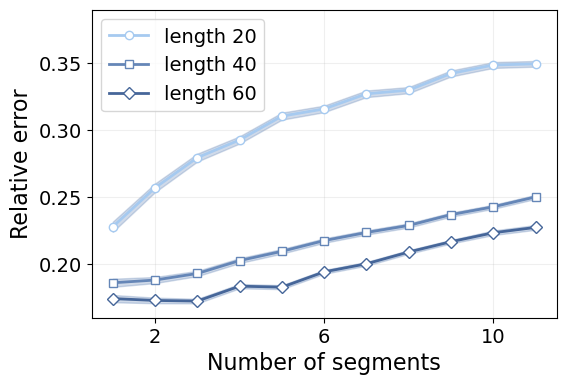

In [ ]:
#| code-fold: true
markers = ['o', 's', 'D']
shades_blue = [colors_light[0], colors[0], colors_dark[0]]
n_seg_rel_error = ds.n_cp.unique().astype(int) + 1

fig = plt.figure(figsize=(1.5*fig_size, fig_size))
for k, (val, err, length) in enumerate(zip(rel_err_per_cp, rel_err_sem_per_cp, segment_lengths)):
    plt.plot(n_seg_rel_error, val, marker = markers[k], label=f"length {length}", c=shades_blue[k],
               markerfacecolor='w', lw=linewidth)
    plt.fill_between(n_seg_rel_error, val - err, val + err, alpha=0.3, color=colors[0])
plt.xticks([2, 6, 10])
plt.ylim([0.16, 0.39])
plt.legend(fontsize=14, loc='upper left')
plt.xlabel("Number of segments", fontsize=16)
plt.ylabel("Relative error", fontsize=16)
plt.grid(alpha=alpha_grid)
plt.tick_params(labelsize=14)

We see that the error increases linearly with the number of segments. This means that every additional segment adds the same source of errors despite of how many there may already be.

Furthermore, we see that the segment length has a much larger impact than the number of segments. For instance, it is harder to characterize a trajectory with two segments of length 20 (40 time steps in total), than one with 11 segments of length 40 (440 time steps in total). However, in concordance with the first results in this tutorial, once we reach a certain minimum length, the error stabilizes.

## Changepoint detection

Let's see now the impact on the changepoint detection task. We will compute the JI as a function of the number of segments.

First of all, we filter out those trajectories without any changepoint.

In [ ]:
ds_cp = ds[ds.n_cp != 0].reset_index(drop=True)

Now let's calculate the true positives, false positives and false negatives of every prediction to obtain the JI (see above and our [model evaluation methods](https://borjarequena.github.io/step/source/utils.html#model-evaluation)).

In [ ]:
j_idx_parameters = {'tp': [], 'fp': [], 'fn': []}
for _, (pred, cp) in ds_cp[['pred', 'cp']].iterrows():
    metrics = evaluate_cp_prediction(cp, ruptures_cp(pred.numpy(), pen=2.))
    for k, v in metrics.items():
        if k in j_idx_parameters.keys():
            j_idx_parameters[k].append(v)

for k, v in j_idx_parameters.items():
    ds_cp[k] = v

Finally, we can compute the JI as function of the number of changepoints for every segment length.

In [ ]:
j_idx_per_cp = np.zeros_like(rel_err_per_cp)[:, :-1]
for i, length in enumerate(ds_cp.seg_len.unique()):
    for j, n_cp in enumerate(ds_cp.n_cp.unique().astype(int)):
        mask = (ds_cp.seg_len == length) & (ds_cp.n_cp == n_cp)
        j_idx_per_cp[i, j] = jaccard_index(ds_cp.tp[mask].sum(),
                                           ds_cp.fp[mask].sum(),
                                           ds_cp.fn[mask].sum())

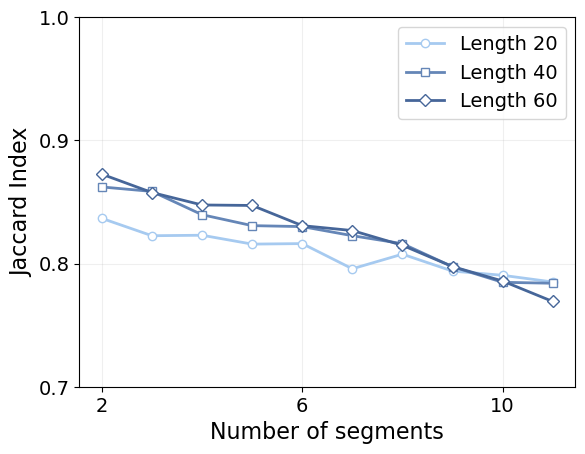

In [ ]:
#| code-fold: true
n_seg = ds_cp.n_cp.unique().astype(int) + 1
for k, (val, length) in enumerate(zip(j_idx_per_cp, segment_lengths)):
    plt.plot(n_seg, val, marker = markers[k], label=f"Length {length}", c=shades_blue[k],
               markerfacecolor='w', lw=linewidth)
    # ax[1].fill_between(n_seg, val - err, val + err, alpha=0.3, color=colors[0])
xticks = [2, 6, 10]
plt.xticks(xticks)
plt.ylim([0.7, 1.])
plt.yticks([0.7, 0.8, 0.9, 1.])
plt.grid(alpha=alpha_grid)
plt.legend(fontsize=14)
plt.ylabel("Jaccard Index", fontsize=16)
plt.xlabel("Number of segments", fontsize=16)
plt.tick_params(labelsize=14)

Again, we see that shorter segments are harder to characterize, and that segment length does not play a significant role beyond a certain threshold, as the curves for length 40 and 60 are very similar. In this case, we see that the trajectory length does, indeed, punish the performance more than it does for the pointwise error, as the model tends to accumulate missclasified changepoints along the way.

# Resilience to noise

As a final test, we assess the resilience of STEP to localization noise. We simulate it as white nose added to the trajectories $\sim\mathcal{N}(0,\sigma_{\text{noise}})$, just as we did in the [model training tutorial](https://borjarequena.github.io/step/tutorials/model_training.html).

This way, we use the first noiseless test set from the beginning of this tutorial, and we add noise at different $\sigma_{\text{noise}}$.

## (Optional) Load the data

Load the test set in case it is not in memory.

In [ ]:
ds = load_dataset(n_change="1_to_4", dim=dim, bm=True, name="test")

## Get the predictions

Let's get the predictions over the noisy trajectories. First of all, however, we will pre-compute the logarithm of our targets and rename some columns.

In [ ]:
ds['y'] = ds['y_exp'].apply(torch.squeeze)
ds['y_log'] = ds['y'].apply(torch.log10)
# ds['cp'] = ds['cp'].apply(lambda x: x.numpy())
ds = ds.drop(columns=['y_mod', 'y_exp', 'models', 'exps'])

To make the most out of our trajectories, we will add 128 random levels of noise to each of them. We sample $\sigma_{\text{noise}}\in[10^{-6}, 10^0]$ uniformly in log space.

In [ ]:
noise_samples = 128
noise_max, noise_min = 0, -6
noise_range = noise_max - noise_min
noise_traj = torch.rand(ds.shape[0], noise_samples)*noise_range + noise_min


Just like we have done at the beginning, we can compare the segment-wise prediction of STEP with the TA-MSD baseline.

In [ ]:
shape = (ds.shape[0], len(ds.x[0]), noise_traj.shape[1])
pred_noise = torch.zeros(shape)
pred_seg_noise = torch.zeros(shape) 
pred_tamsd_noise = torch.zeros(shape)

for i, (x, cps) in tqdm(ds[['x','cp']].iterrows()):
    noise = torch.randn(noise_samples, *x.T.shape)*10**noise_traj[i]
    noisy_x = x.T.unsqueeze(0) + noise.unsqueeze(-1).unsqueeze(-1)
    noisy_x -= noisy_x[:, 0].unsqueeze(1)
    split_x = split_tensor(noisy_x.transpose(1, 0), cps)
    
    pred_noise[i] = predict(learn_diff.model, noisy_x).T
    
    pred_seg, pred_tamsd = [], []
    for seg_x in split_x:
        seg_x = (seg_x - seg_x[0]).transpose(1, 0)
        ones = torch.ones(seg_x.shape[1])
        pred = to_detach(learn_diff.model(seg_x.cuda()).squeeze())
        pred_seg.append(pred)
        pred_tamsd.append(torch.stack([ones*diffusion_coefficient_tamsd(s)
                                       for s in seg_x]))
        
    pred_seg_noise[i] = torch.cat(pred_seg, axis=-1).T
    pred_tamsd_noise[i] = torch.cat(pred_tamsd, axis=-1).T
    
predictions = dict(zip(['full', 'seg', 'tamsd'],
                       [pred_noise, pred_seg_noise, pred_tamsd_noise]))

0it [00:00, ?it/s]

With the predictions, let's compute the error performed at every point as a function of the noise to signal ratio $\sigma_{\text{noise}}/D$.

Since the diffusion coefficient changes along the trajectories, we need to compute $\sigma_{\text{noise}}/D$ at every time step of all the trajectories.

In [ ]:
y = torch.stack([t for t in ds['y_log'].values])
rel_noise = noise_traj.unsqueeze(1) - y.unsqueeze(-1)

Now we can compute the relative errors performed by every method at each time step.

In [ ]:
errors = {k: p - y.unsqueeze(-1) if k != 'tamsd'
          else p/(10**y.unsqueeze(-1)) - 1 # Already get rel error for tamsd
          for k, p in predictions.items()} 

Since we're dealing with infinitely many combinations of $\sigma_{\text{noise}}$ and $D$, we compute the error as a function of small intervals of $\sigma_{\text{noise}}/D$. 

In [ ]:
bins = torch.linspace(rel_noise.min(), rel_noise.max(), 100)
noise_err, noise_err_std, x, counts = [], [], [], []

for low, high in tqdm(zip(bins[:-1], bins[1:])):
    mask = (rel_noise >= low) & (rel_noise <= high)
    x.append((low + high)/2)
    counts.append(mask.float().sum())
    rel_errors = [(10**err[mask] - 1).abs() if k != 'tamsd'
                  else err[mask].abs() 
                  for k, err in errors.items()]
    noise_err.append(tensor([rel_err.mean() for rel_err in rel_errors]))
    noise_err_std.append(tensor([rel_err.std() for rel_err in rel_errors]))
    
noise_err = torch.stack(noise_err)
noise_err_std = torch.stack(noise_err_std)
x = torch.stack(x)
counts = torch.stack(counts)

0it [00:00, ?it/s]

Let's save these to process later.

In [ ]:
fig_name = "noise_analysis"
plot_path = (FIG_PATH/fig_name).with_suffix(".pkl")
plot_data = (noise_err, noise_err_std, x, counts)
with open(plot_path, 'wb') as f:
    pickle.dump(plot_data, f, protocol=pickle.HIGHEST_PROTOCOL)

And let's see what we got!

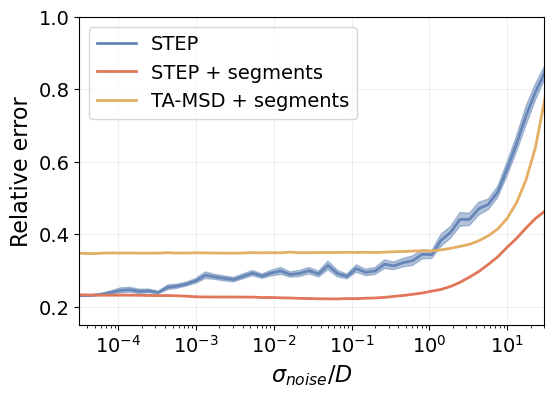

In [ ]:
#| code-fold: true
sem = noise_err_std/counts.sqrt().unsqueeze(-1)

plt.figure(figsize=(1.5*fig_size, fig_size))
for k, (err, s) in enumerate(zip(noise_err.T, sem.T)):
    plt.semilogx(10**x, err, '-', linewidth=2., c=colors[k], label=labels[k])
    plt.fill_between(10**x, err - s, err + s, alpha=0.5, color = colors[k])
plt.legend(fontsize=14)
plt.grid(alpha = alpha_grid)
plt.xlim([10**(-4.5), 30])
plt.ylim([0.15, 1.])
plt.tick_params(labelsize=14)
plt.xlabel(r"$\sigma_{noise}/D$", fontsize=16)
plt.ylabel("Relative error", fontsize=16)
plt.tick_params(labelsize=14)

STEP is significantly more resilient to localization noise than the TA-MSD method. It only gets outperformed at noise levels that are greater than the actual signal, which are unrealistic experimental conditions. 